Produces graphs not made during the city_panel build sequence

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression


INPATH = r"data\city_panel.csv"

df = pd.read_csv(INPATH)
df['city_name'] = df['city'].str.replace(r'\d+', '', regex=True)
df.columns

Index(['Unnamed: 0', 'city', 'genre', 'style', 'start_year', 'end_year',
       'num_releases', 'num_master_ids', 'releases_per_master_mean',
       'releases_per_master_median', 'releases_per_master_10th',
       'releases_per_master_25th', 'releases_per_master_75th',
       'releases_per_master_90th', 'num_nodes', 'num_edges', 'density',
       'components', 'largest_cc_size', 'avg_degree', 'max_degree',
       'min_degree', 'entropy', 'period', 'avg_forward', 'avg_backward',
       'avg_taddy', 'taddy_p75', 'taddy_p90', 'taddy_p95', 'avg_first_release',
       'count', 'Electronic_total', 'Electronic_share', 'Hip Hop_total',
       'Hip Hop_share', 'Jazz_total', 'Jazz_share', 'Funk / Soul_total',
       'Funk / Soul_share', 'Classical_total', 'Classical_share',
       'Latin_total', 'Latin_share', 'Pop_total', 'Pop_share', 'Reggae_total',
       'Reggae_share', 'Folk, World, & Country_total',
       'Folk, World, & Country_share', 'Rock_total', 'Rock_share',
       'Stage & Screen_t

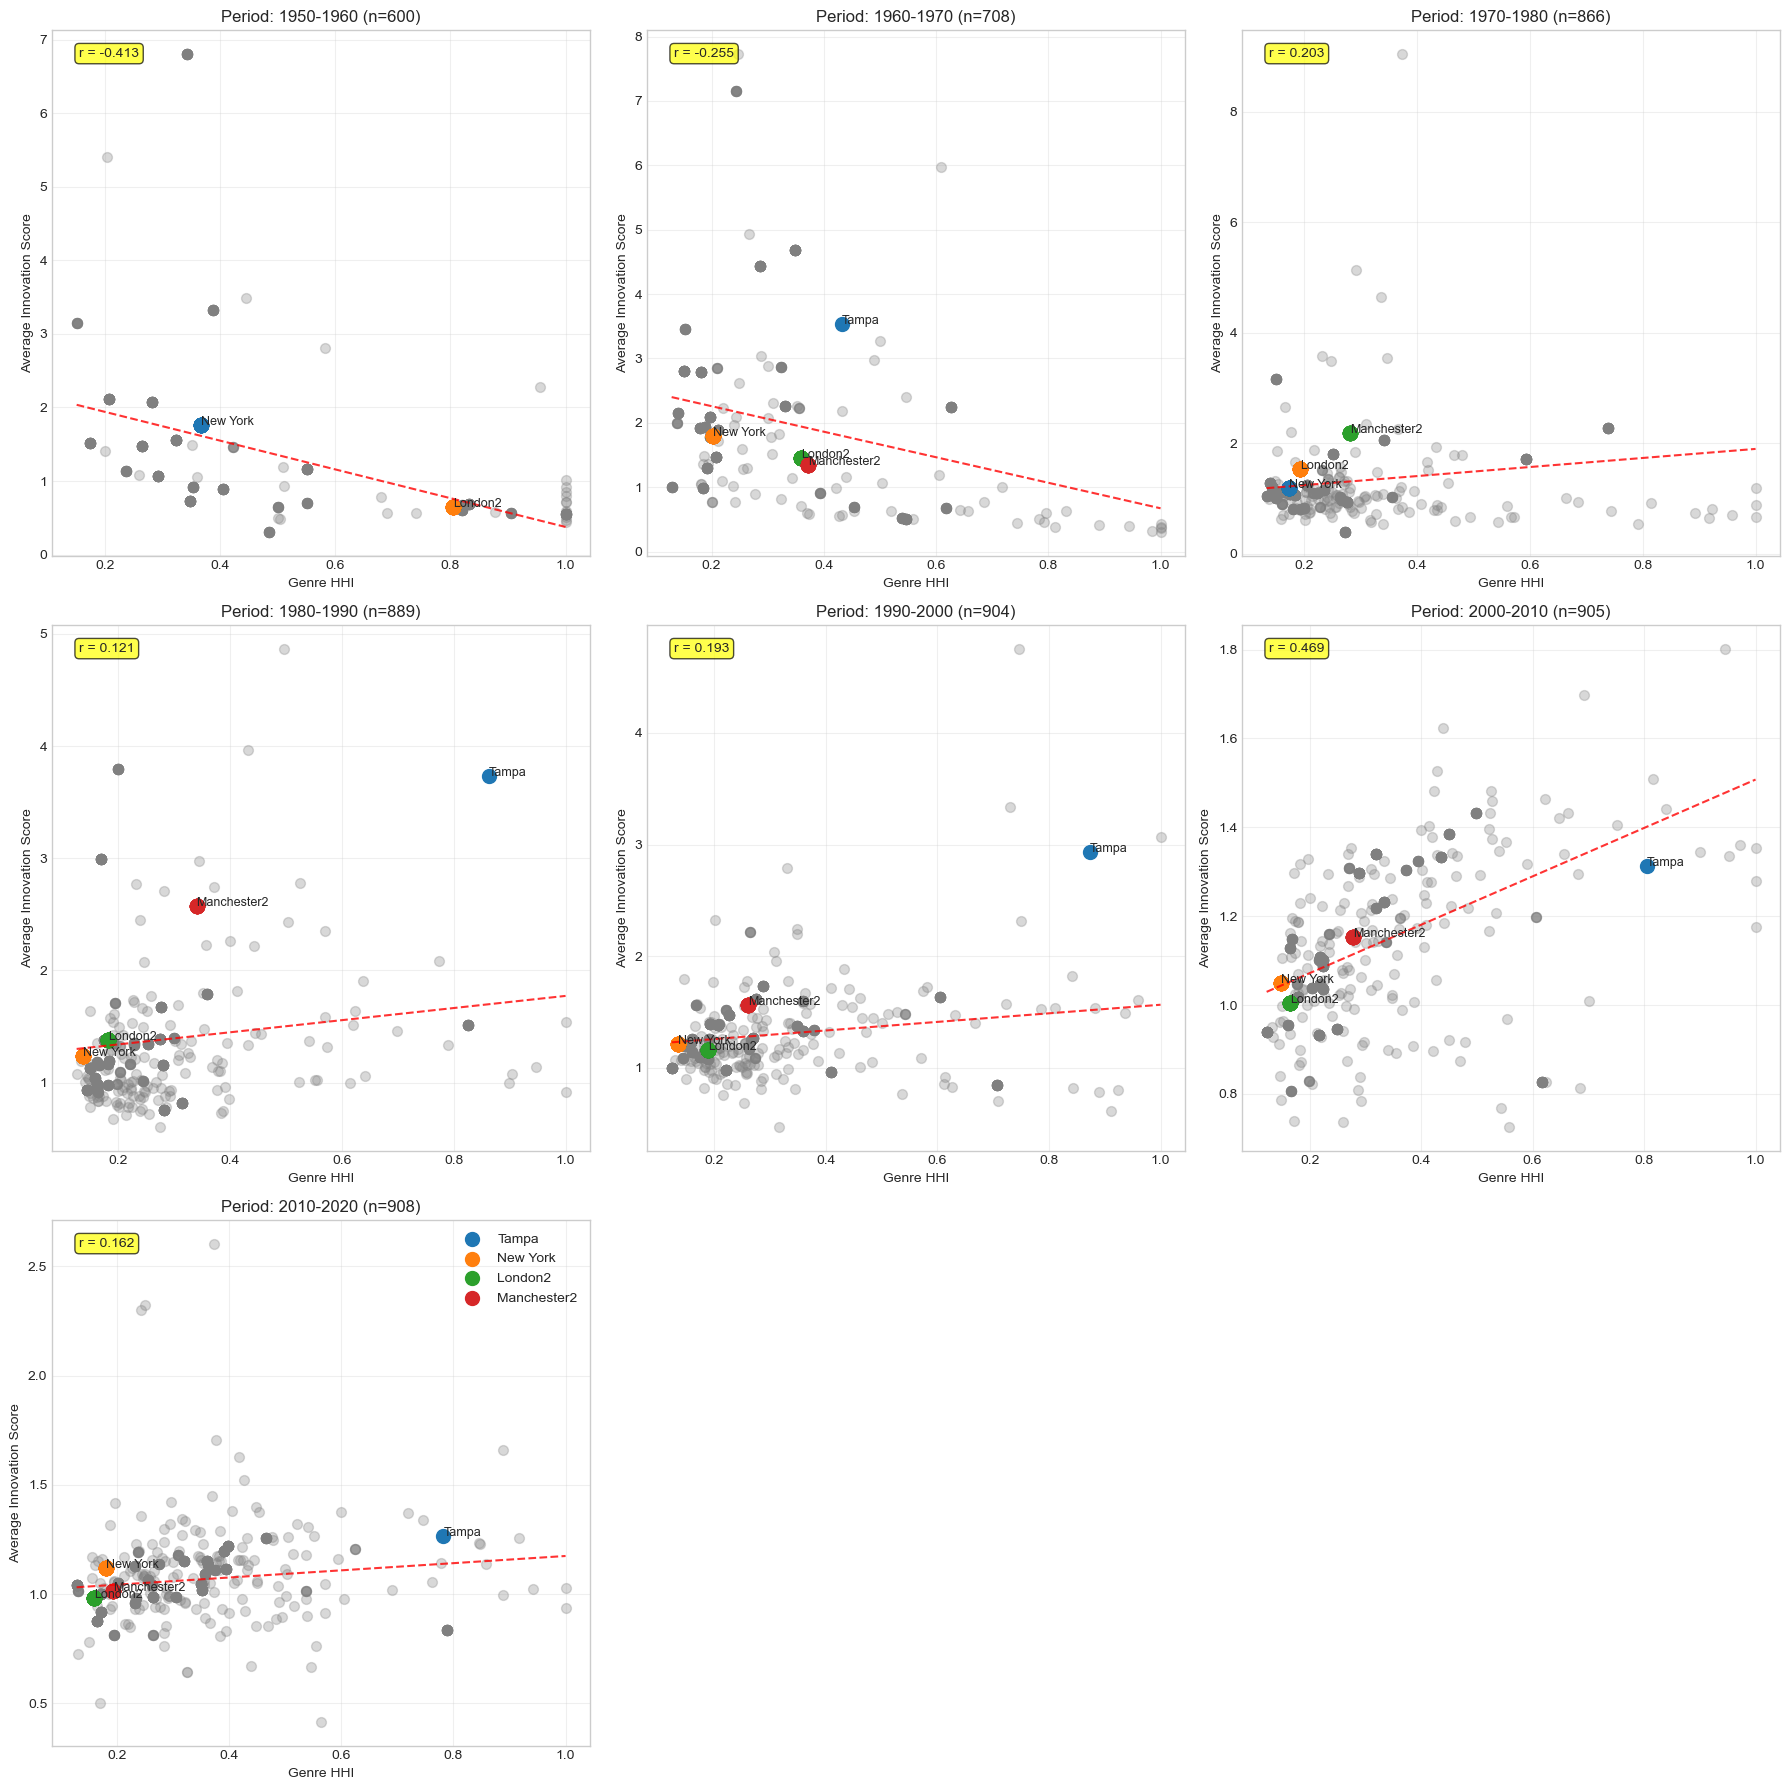

In [9]:
cities_to_label = [ "Tampa", "New York", "London2", "Manchester2"]

#decade start years only
all_periods = df['period'].dropna().unique()
periods = [p for p in all_periods if int(p.split('-')[0]) % 10 == 0]
n_periods = len(periods)
cols = 3
rows = (n_periods + cols - 1) // cols

# Create scatterplots for each period using genre HHI
plt.figure(figsize=(18, 6 * rows))

for i, period in enumerate(sorted(periods), 1):
    period_data = df[
        (df['period'] == period) & 
        df['avg_taddy'].notna() & 
        df['genre_hhi'].notna()
    ]
    
    plt.subplot(rows, cols, i)
    
    if len(period_data) > 0:
        # Plot all cities
        plt.scatter(period_data['genre_hhi'], period_data['avg_taddy'], alpha=0.3, s=50, color='gray')
        
        # Highlight and label specific cities
        for city in cities_to_label:
            city_data = period_data[period_data['city'] == city]
            if not city_data.empty:
                plt.scatter(city_data['genre_hhi'], city_data['avg_taddy'], s=100, label=city)
                plt.text(city_data['genre_hhi'].iloc[0], city_data['avg_taddy'].iloc[0], city, fontsize=9)

        # Add trendline for all data in the period
        if len(period_data) > 1:
            z = np.polyfit(period_data['genre_hhi'], period_data['avg_taddy'], 1)
            p = np.poly1d(z)
            plt.plot(period_data['genre_hhi'].sort_values(), p(period_data['genre_hhi'].sort_values()), "r--", alpha=0.8)
            
            # Add correlation coefficient for this period
            correlation = period_data['avg_taddy'].corr(period_data['genre_hhi'])
            plt.text(0.05, 0.95, f'r = {correlation:.3f}', transform=plt.gca().transAxes, 
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.xlabel('Genre HHI')
    plt.ylabel('Average Innovation Score')
    plt.title(f'Period: {period} (n={len(period_data)})')
    plt.grid(True, alpha=0.3)
    
    # Add legend to final plot
    if i == 7:
        plt.legend()

plt.tight_layout()
plt.show()

c:\Users\maxmo\anaconda3\envs\GRL_env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


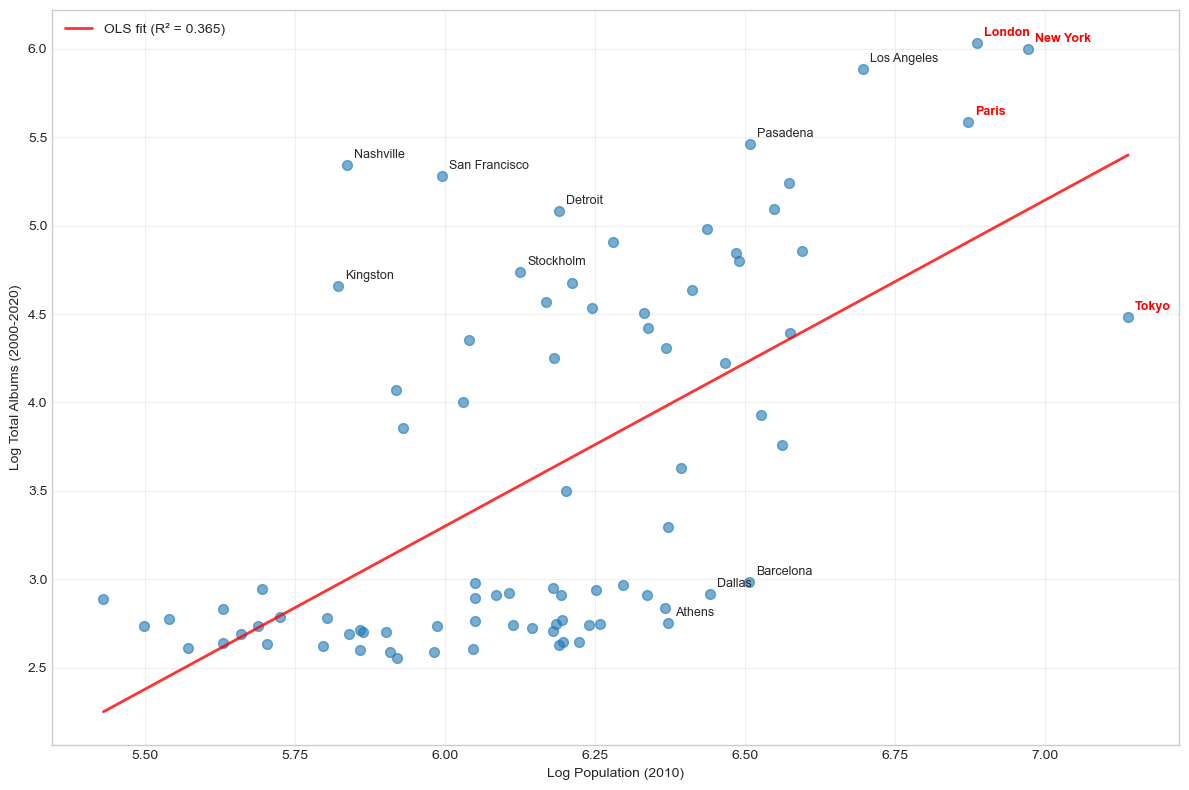

In [12]:
subset_2k = df[df['start_year'] >=2000]
LABEL_SET = ['New York', 'London', 'Paris', 'Tokyo']

subset_2k = df.dropna(subset=['num_master_ids', 'est_2010_population'])

# Group data by city
grouped_data = subset_2k.groupby('city').agg({
    'est_2010_population': 'max',
    'num_master_ids': 'sum',
    'city_name': 'first'
}).reset_index()

grouped_data.columns = ['city', '2010_population', 'total_albums', 'city_name']

#covert population and total_albums to logs
grouped_data['log_population'] = np.log10(grouped_data['2010_population'] + 1)
grouped_data['log_total_albums'] = np.log10(grouped_data['total_albums'] + 1)

# Fit OLS regression
X = grouped_data[['log_population']]
y = grouped_data['log_total_albums']
reg = LinearRegression().fit(X, y)

# Calculate predicted values and residuals
grouped_data['predicted_albums'] = reg.predict(X)
grouped_data['residuals'] = abs(grouped_data['log_total_albums'] - grouped_data['predicted_albums'])

# Find outliers based on absolute residuals
outliers = grouped_data.nlargest(10, 'residuals')

#scatterplot of the population against total albums. label four outliers with the corresponding 'city_name'
#  and label anything where the 'city_name' of the 'city' appears in the Label_set

plt.figure(figsize=(12, 8))

# Create scatterplot
plt.scatter(grouped_data['log_population'], grouped_data['log_total_albums'], alpha=0.6, s=50)

# Add OLS regression line
x_line = np.linspace(grouped_data['log_population'].min(), grouped_data['log_population'].max(), 100)
y_line = reg.predict(x_line.reshape(-1, 1))
plt.plot(x_line, y_line, 'r-', alpha=0.8, linewidth=2, label=f'OLS fit (R² = {reg.score(X, y):.3f})')

# Label outliers
for _, row in outliers.iterrows():
    plt.annotate(row['city_name'], 
                (row['log_population'], row['log_total_albums']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

# Label cities in LABEL_SET
label_cities = grouped_data[grouped_data['city_name'].isin(LABEL_SET)]
for _, row in label_cities.iterrows():
    plt.annotate(row['city_name'], 
                (row['log_population'], row['log_total_albums']),
                xytext=(5, 5), textcoords='offset points', fontsize=9, 
                color='red', fontweight='bold')

plt.xlabel('Log Population (2010)')
plt.ylabel('Log Total Albums (2000-2020)')
#plt.title('Population vs Total Albums (2000-2010)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import dask.dataframe as dd

TABLE_PATH = r"data\full_table_v2.csv"
MASTERS_PATH = r"data\masters_v2.csv"

masters = dd.read_csv(MASTERS_PATH, assume_missing='True')
full_table = dd.read_csv(TABLE_PATH, assume_missing='True')

print(masters.columns)
print("*" * 40)
print(full_table.columns)

Index(['master_id', 'artist_ids', 'genres', 'styles', 'data_quality', 'year',
       'title'],
      dtype='object')
****************************************
Index(['master_id', 'artist_id', 'genre', 'style', 'data_quality_y', 'year',
       'title', 'recorded_id', 'latitude', 'longitude', 'geocoding_method',
       'geometry', 'city', 'est_2010_population', 'max_bb_xma', 'member_ids',
       'artist_name', 'artist_info_data_quality', 'new_style_1',
       'novel_style_combo_count'],
      dtype='object')


In [14]:
import ast

# Properly unnest the genres and styles columns from masters data
def safe_literal_eval(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x if x is not None else []

# Apply unnesting to masters data
masters_copy = masters.copy()
for col in ['genres', 'styles']:
    masters_copy[col] = masters_copy[col].apply(safe_literal_eval, meta=('x', 'object'))

# Explode the columns
masters_exploded = masters_copy.explode('genres').explode('styles')

# Rename to singular
masters_exploded = masters_exploded.rename(columns={
    'genres': 'genre',
    'styles': 'style'
})

# Count genres in masters (properly unnested) - ensure each master_id/genre pair is counted only once
masters_genre_subset = masters_exploded[['master_id', 'genre']].dropna(subset=['genre']).drop_duplicates()
masters_genre_counts = masters_genre_subset['genre'].value_counts().compute()

# Count genres in full table - ensure each master_id/genre pair is counted only once
full_table_genre_subset = full_table[['master_id', 'genre']].dropna(subset=['genre']).drop_duplicates()
full_table_genre_counts = full_table_genre_subset['genre'].value_counts().compute()

# Merge genre counts
genre_table = pd.DataFrame({
    'genre': masters_genre_counts.index,
    'masters_count': masters_genre_counts.values
}).merge(
    pd.DataFrame({
        'genre': full_table_genre_counts.index,
        'full_sample_count': full_table_genre_counts.values
    }),
    on='genre',
    how='outer'
).fillna(0)

# Calculate representation ratio
genre_table['represented'] = genre_table['full_sample_count'] / genre_table['masters_count']

print("Genre analysis:")
print(genre_table.head())

# REPEAT FOR STYLES
# Count styles in masters (properly unnested) - ensure each master_id/style pair is counted only once
masters_style_subset = masters_exploded[['master_id', 'style']].dropna(subset=['style']).drop_duplicates()
masters_style_counts = masters_style_subset['style'].value_counts().compute()

# Count styles in full table - ensure each master_id/style pair is counted only once
full_table_style_subset = full_table[['master_id', 'style']].dropna(subset=['style']).drop_duplicates()
full_table_style_counts = full_table_style_subset['style'].value_counts().compute()

# Merge style counts
style_table = pd.DataFrame({
    'style': masters_style_counts.index,
    'masters_count': masters_style_counts.values
}).merge(
    pd.DataFrame({
        'style': full_table_style_counts.index,
        'full_sample_count': full_table_style_counts.values
    }),
    on='style',
    how='outer'
).fillna(0)

# Calculate representation ratio
style_table['represented'] = style_table['full_sample_count'] / style_table['masters_count']

print("\nStyle analysis:")
print(style_table.head())

Genre analysis:
              genre  masters_count  full_sample_count  represented
0                 1              6                  0          0.0
1             Blues          51132               8611     0.168407
2  Brass & Military           8179                516     0.063088
3        Children's          24052               1638     0.068102
4         Classical         147979              27887     0.188452

Style analysis:
        style  masters_count  full_sample_count  represented
0         AOR           4401               1138     0.258578
1  Aboriginal            558                 70     0.125448
2    Abstract          20901               1152     0.055117
3        Acid          13616                122      0.00896
4  Acid House           3998                141     0.035268


In [ ]:
style_table.to_csv(r"data\explorations\coverage_by_style.csv")
genre_table.to_csv(r"data\explorations\coverage_by_genre.csv")

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\maxmo\\Dropbox\\GDS\\Dissertation\\discogs\\data\\explorations\\coverage_by_genre.csv'

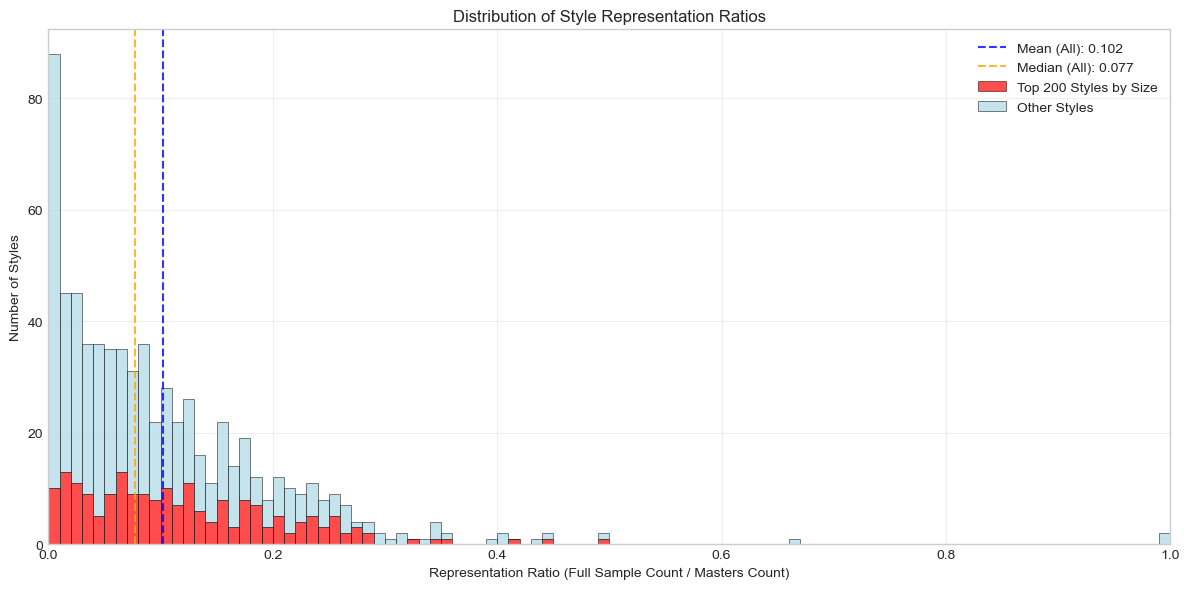

Summary statistics for style representation:
Mean: 0.102
Median: 0.077
Min: 0.000
Max: 1.000


In [16]:
# Generate histogram of styles by 'representation'
plt.figure(figsize=(12, 6))

N_BINS = 100
bins = np.linspace(0, 1, N_BINS + 1)

all_counts, _ = np.histogram(style_table['represented'], bins=bins)
top_200_styles = style_table.nlargest(200, 'masters_count')
top_200_counts, _ = np.histogram(top_200_styles['represented'], bins=bins)

bin_centers = (bins[:-1] + bins[1:]) / 2
width = bins[1] - bins[0]

plt.bar(bin_centers, top_200_counts, width=width, alpha=0.7, 
        color='red', edgecolor='black', linewidth=0.5, label='Top 200 Styles by Size')
plt.bar(bin_centers, all_counts - top_200_counts, width=width, alpha=0.7, 
        color='lightblue', edgecolor='black', linewidth=0.5, bottom=top_200_counts, 
        label='Other Styles')

plt.xlim(0, 1)
plt.xlabel('Representation Ratio (Full Sample Count / Masters Count)')
plt.ylabel('Number of Styles')
plt.title('Distribution of Style Representation Ratios')
plt.grid(True, alpha=0.3)

mean_rep = style_table['represented'].mean()
median_rep = style_table['represented'].median()
plt.axvline(mean_rep, color='blue', linestyle='--', alpha=0.8, label=f'Mean (All): {mean_rep:.3f}')
plt.axvline(median_rep, color='orange', linestyle='--', alpha=0.8, label=f'Median (All): {median_rep:.3f}')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Summary statistics for style representation:")
print(f"Mean: {mean_rep:.3f}")
print(f"Median: {median_rep:.3f}")
print(f"Min: {style_table['represented'].min():.3f}")
print(f"Max: {style_table['represented'].max():.3f}")

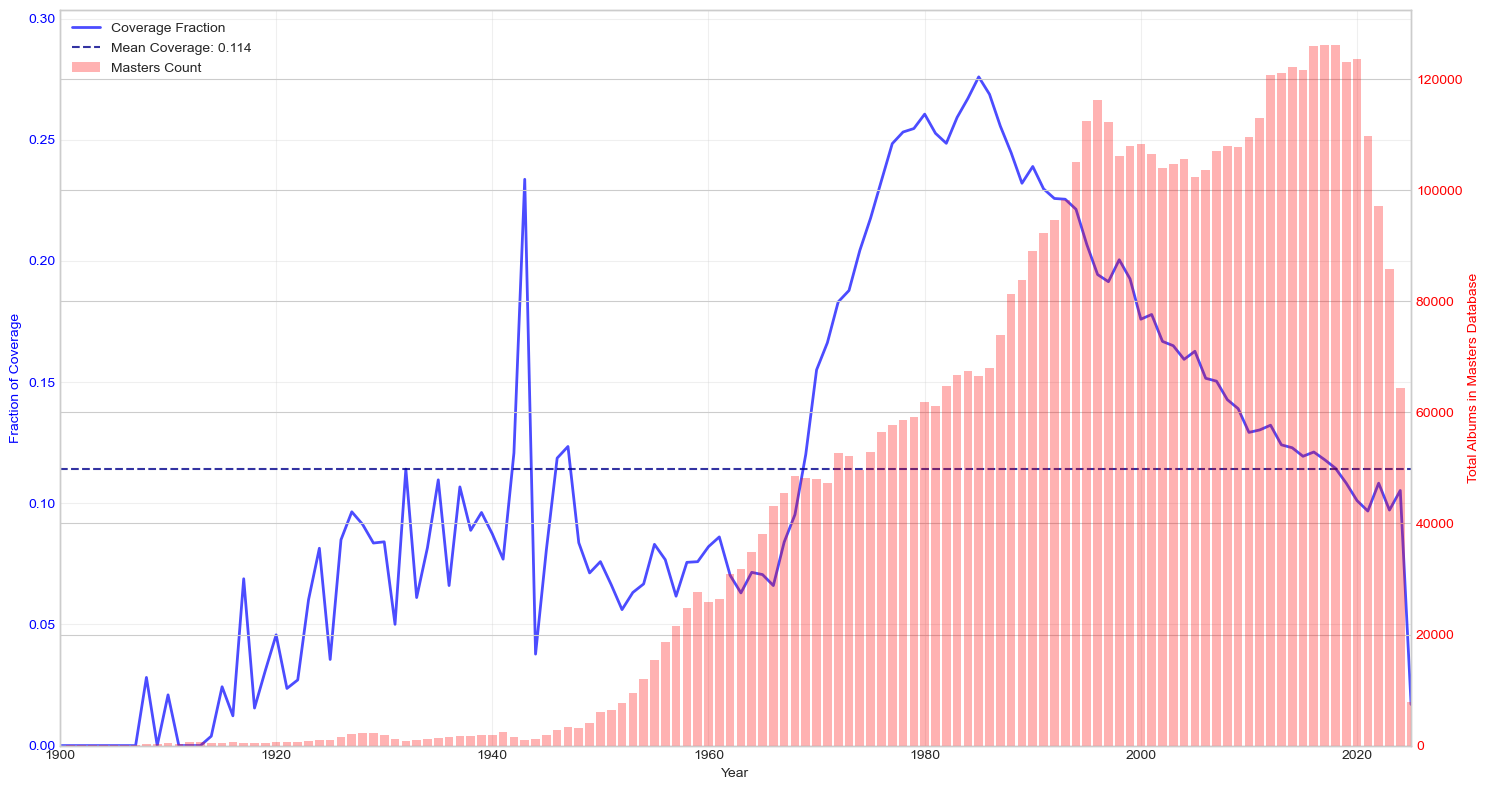

Summary statistics for yearly representation:
Mean: 0.114
Median: 0.097
Min: 0.000
Max: 0.276
Years covered: 1900 - 2025


In [17]:
# Filter both datasets for years between 1900 and 2025
masters_filtered = masters_exploded[
    (masters_exploded['year'] >= 1900) & 
    (masters_exploded['year'] <= 2025) & 
    masters_exploded['year'].notnull()
]

full_table_filtered = full_table[
    (full_table['year'] >= 1900) & 
    (full_table['year'] <= 2025) & 
    full_table['year'].notnull()
]

# Count by year for masters (compute only the filtered subset)
masters_year_counts = masters_filtered['year'].value_counts().compute()

# Count by year for full table
full_table_year_counts = full_table_filtered['year'].value_counts().compute()

# Create time series DataFrame
year_coverage = pd.DataFrame({
    'year': masters_year_counts.index,
    'masters_count': masters_year_counts.values
}).merge(
    pd.DataFrame({
        'year': full_table_year_counts.index,
        'full_sample_count': full_table_year_counts.values
    }),
    on='year',
    how='outer'
).fillna(0)

# Calculate representation fraction
year_coverage['representation_fraction'] = year_coverage['full_sample_count'] / year_coverage['masters_count']
year_coverage['representation_fraction'] = year_coverage['representation_fraction'].replace([np.inf, -np.inf], 0)

# Sort by year for plotting
year_coverage = year_coverage.sort_values('year')

# Create time series plot with secondary axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot representation fraction on primary axis
line1 = ax1.plot(year_coverage['year'], year_coverage['representation_fraction'], 
                 linewidth=2, color='blue', alpha=0.7, label='Coverage Fraction')

ax1.set_xlabel('Year')
ax1.set_ylabel('Fraction of Coverage', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1900, 2025)
ax1.set_ylim(0, year_coverage['representation_fraction'].max() * 1.1)

# Create secondary axis for masters count
ax2 = ax1.twinx()
bars = ax2.bar(year_coverage['year'], year_coverage['masters_count'], 
               alpha=0.3, color='red', width=0.8, label='Masters Count')

ax2.set_ylabel('Total Albums in Masters Database', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add summary statistics
mean_fraction = year_coverage['representation_fraction'].mean()
ax1.axhline(mean_fraction, color='darkblue', linestyle='--', alpha=0.8, 
           label=f'Mean Coverage: {mean_fraction:.3f}')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print(f"Summary statistics for yearly representation:")
print(f"Mean: {mean_fraction:.3f}")
print(f"Median: {year_coverage['representation_fraction'].median():.3f}")
print(f"Min: {year_coverage['representation_fraction'].min():.3f}")
print(f"Max: {year_coverage['representation_fraction'].max():.3f}")
print(f"Years covered: {year_coverage['year'].min():.0f} - {year_coverage['year'].max():.0f}")

In [ ]:
CENTRALITIES_PATH =r"data\total_centrality.csv"

centralities = pd.read_csv(CENTRALITIES_PATH)

Total unique cities in top 10 across all years: 23


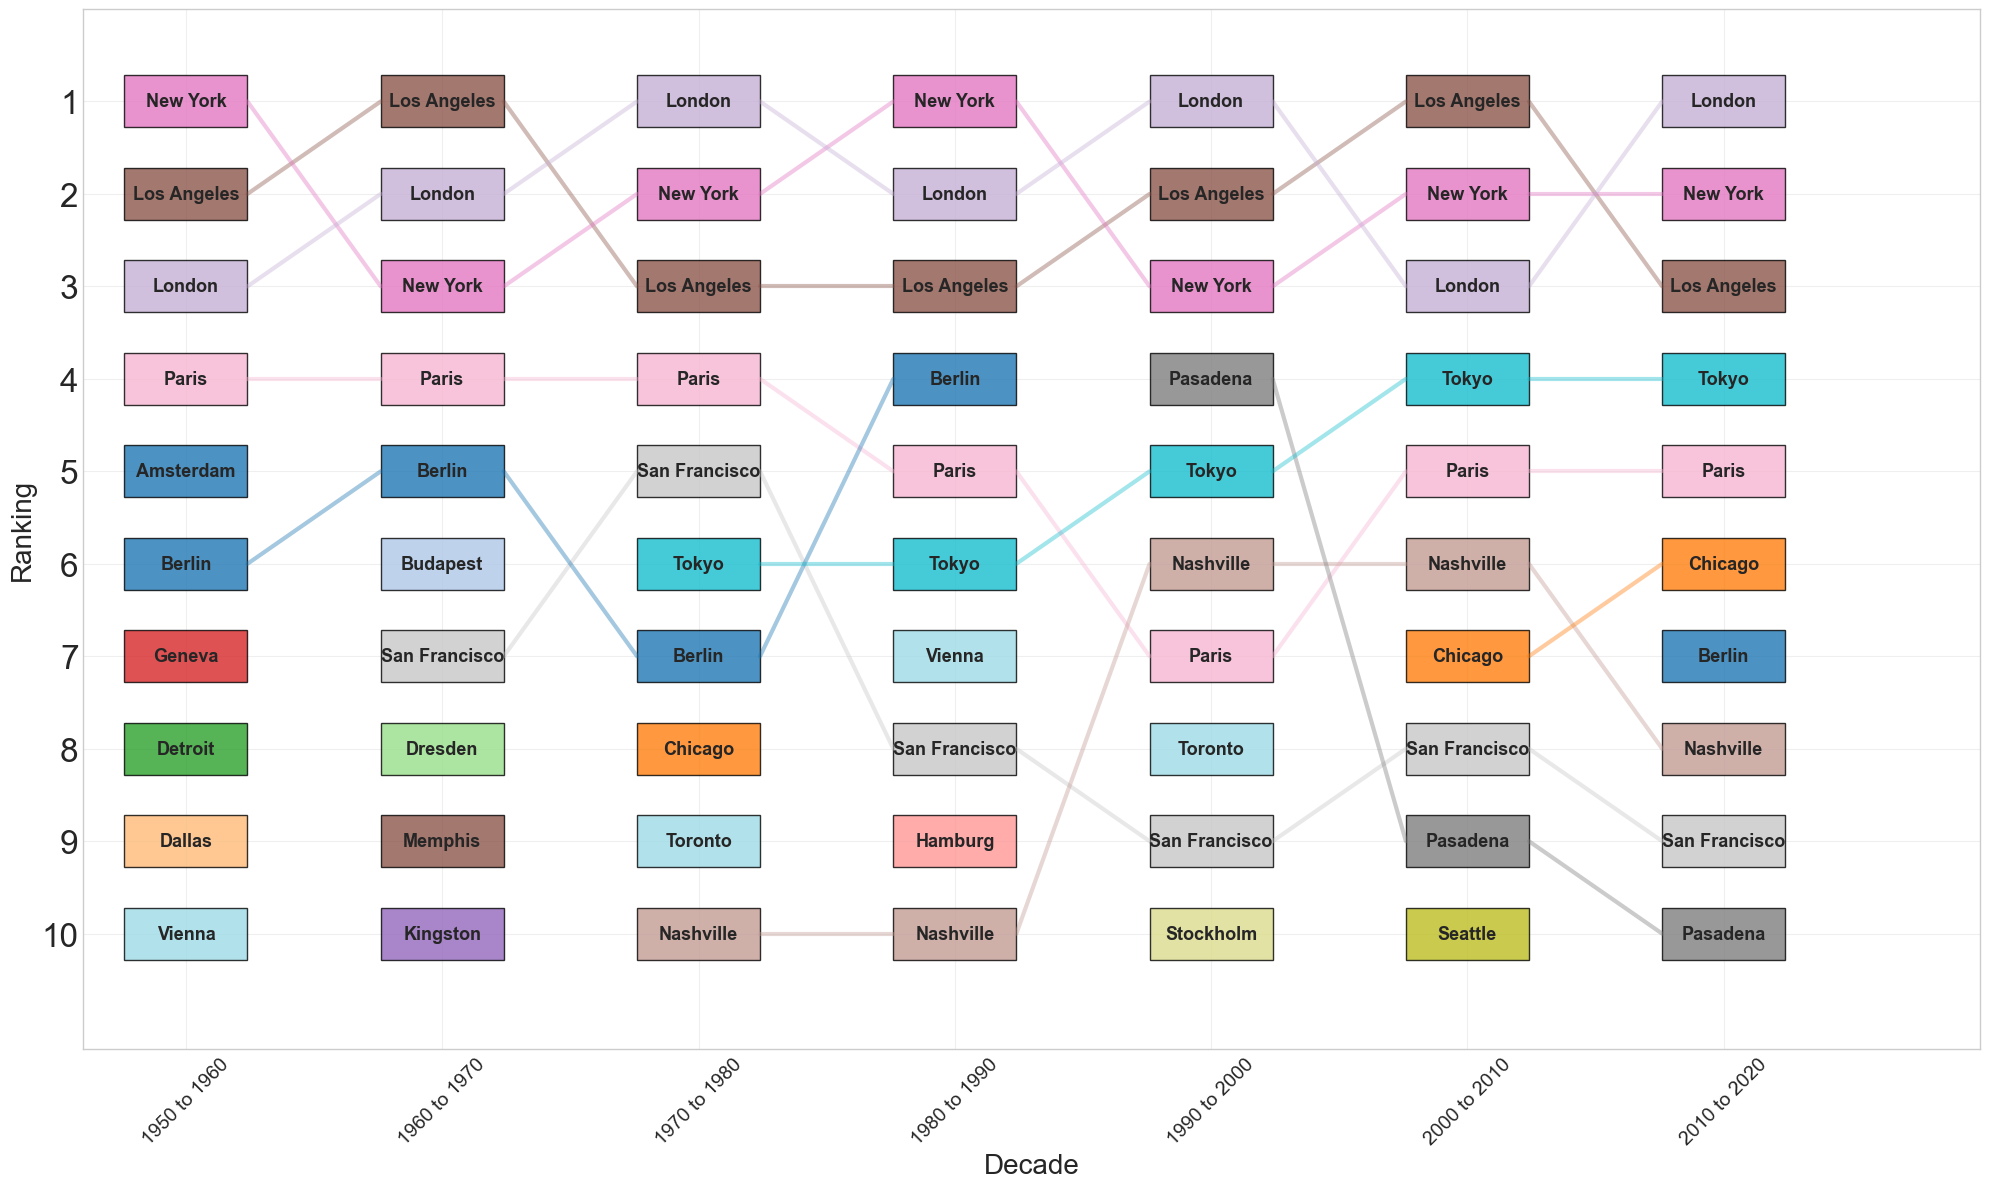

In [20]:
centralities['year'] = centralities['year_range'].str[:4].astype(int)

# Filter data to our main on-decade sample
centralities = centralities[
    (centralities['year'] >= 1950) & 
    (centralities['year'] % 10 == 0)
]

years = sorted(centralities['year'].unique())

# Calculate top 10 rankings for each year
rankings_by_year = {}
all_top_cities = set()

for year in years:
    year_data = centralities[centralities['year'] == year]
    if len(year_data) > 0:
        top_10 = year_data.nlargest(10, 'betweenness_centrality')
        rankings_by_year[year] = top_10.set_index('city')['betweenness_centrality'].sort_values(ascending=False)
        all_top_cities.update(top_10['city'].tolist())

print(f"Total unique cities in top 10 across all years: {len(all_top_cities)}")

# Create flow diagram
fig, ax = plt.subplots(figsize=(20, 12))

# Set up colors for cities (more colors for more cities)
colors = plt.cm.tab20(np.linspace(0, 1, len(all_top_cities)))
city_colors = dict(zip(sorted(all_top_cities), colors))

# Plot settings
year_spacing = 2.5
rank_spacing = 0.8
box_width = 1.2
box_height = 0.45

for i, year in enumerate(years):
    x_pos = i * year_spacing
    
    if year in rankings_by_year and len(rankings_by_year[year]) > 0:
        ranked_cities = rankings_by_year[year].index.tolist()
        
        for rank, city in enumerate(ranked_cities):
            y_pos = (9 - rank) * rank_spacing 
            
            # Draw rectangle for city
            rect = Rectangle((x_pos - box_width/2, y_pos - box_height/2), 
                           box_width, box_height, 
                           facecolor=city_colors[city], 
                           edgecolor='black', 
                           alpha=0.8)
            ax.add_patch(rect)
            
            # Add city name (clean up numbers)
            clean_city = city.replace('2', '').replace('1', '')
            ax.text(x_pos, y_pos, clean_city, 
                   ha='center', va='center', fontsize=13, fontweight='bold')
            
#connecting lines
for i in range(len(years) - 1):
    year1, year2 = years[i], years[i + 1]
    
    if year1 in rankings_by_year and year2 in rankings_by_year:
        cities1 = rankings_by_year[year1].index.tolist()
        cities2 = rankings_by_year[year2].index.tolist()

        for city in all_top_cities:
            if city in cities1 and city in cities2:
                rank1 = cities1.index(city)
                rank2 = cities2.index(city)
                
                x1 = i * year_spacing + box_width/2
                x2 = (i + 1) * year_spacing - box_width/2
                y1 = (9 - rank1) * rank_spacing
                y2 = (9 - rank2) * rank_spacing
                
                # Line thickness based on ranking (thicker for higher ranks)
                linewidth = 3 #max(1, 4 - (rank1 + rank2) / 4)
                
                ax.plot([x1, x2], [y1, y2], 
                       color=city_colors[city], alpha=0.4, linewidth=linewidth)

# Customize plot
ax.set_xlim(-1, len(years) * year_spacing)
ax.set_ylim(-1, 10 * rank_spacing)
ax.set_xticks([i * year_spacing for i in range(len(years))])
ax.set_xticklabels([f"{int(year)} to {int(year) + 10}" for year in years], rotation=45, fontsize=14)
ax.set_yticks([i * rank_spacing for i in range(10)])
ax.set_yticklabels([f"{10 - i}" for i in range(10)], fontsize=24)

plt.xlabel('Decade', fontsize=20)
plt.ylabel('Ranking', fontsize=20)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Calculate total master IDs per city
city_master_totals = df.groupby('city')['num_master_ids'].sum()

# Filter cities with more than 200 total master IDs
large_cities = city_master_totals[city_master_totals > 200].index

# Find top 20 cities by avg_first_release_taddy (only among large cities)
top_20_cities = df[df['city'].isin(large_cities)].groupby('city')['avg_first_release'].mean().sort_values(ascending=False).head(20)

print("Top 20 cities by average first release Taddy score")
print("=" * 75)
for i, (city, score) in enumerate(top_20_cities.items(), 1):
    clean_city = city.replace('2', '').replace('1', '')
    total_masters = city_master_totals[city]
    print(f"{i:2d}. {clean_city:<20} {score:.4f} ")

Top 20 cities by average first release Taddy score
 1. Seattle              4.9404 
 2. Detroit              3.1735 
 3. Miami                2.3344 
 4. Chicago              2.2766 
 5. Vancouver            2.2447 
 6. Manchester           2.1720 
 7. Dublin               2.1355 
 8. Verona               2.1111 
 9. Memphis              2.0819 
10. Cleveland            2.0712 
11. San Francisco        2.0482 
12. Athens               2.0067 
13. Melbourne            1.9647 
14. Milan                1.9522 
15. Philadelphia         1.9166 
16. Barcelona            1.9139 
17. Bologna              1.8932 
18. Helsinki             1.8912 
19. Liverpool            1.8567 
20. Kingston             1.8243 


In [ ]:
import pandas as pd

TADDY_PATH = r"data\taddy_results.csv"
taddy = pd.read_csv(TADDY_PATH)
INPATH = r"data\full_table_v2.csv"
df = pd.read_csv(INPATH)

STYLE = "New Wave"
df_single_style = df[df['style'] == STYLE]

graphing_frame = pd.merge(df_single_style, taddy, how='inner', on='master_id')
graphing_frame.columns

Index(['master_id', 'artist_id', 'genre', 'style', 'data_quality_y', 'year_x',
       'title', 'recorded_id', 'latitude', 'longitude', 'geocoding_method',
       'geometry', 'city', 'est_2010_population', 'max_bb_xma', 'member_ids',
       'artist_name', 'artist_info_data_quality', 'new_style_1',
       'novel_style_combo_count', 'year_y', 'forward', 'backward', 'taddy'],
      dtype='object')

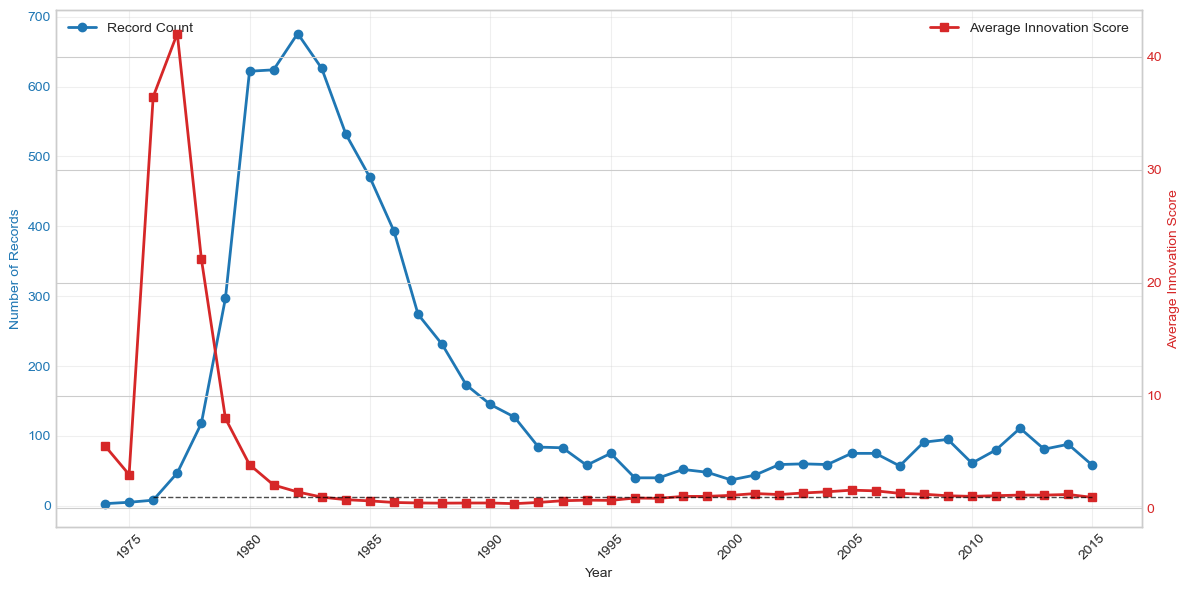

In [23]:
# Create figure with two y-axes
yearly_counts = graphing_frame.groupby('year_x')['master_id'].count()
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Records', color=color)
ax1.plot(yearly_counts.index, yearly_counts.values, marker='o', linewidth=2, color=color, label='Record Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1955, 2016, 5))
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
color = 'tab:red'

yearly_taddy = graphing_frame.groupby('year_x')['taddy'].mean()

ax2.set_ylabel('Average Innovation Score', color=color)
ax2.plot(yearly_taddy.index, yearly_taddy.values, marker='s', linewidth=2, color=color, label='Average Innovation Score')
ax2.tick_params(axis='y', labelcolor=color)

x_min = yearly_taddy.index.min()
x_max = yearly_taddy.index.max()
ax2.plot([x_min + 2, x_max], [1, 1], color='black', linestyle='--', linewidth=1, alpha=0.7)

# Add title and legends
#plt.title(f'Number of {STYLE} Records and Average Innovation Score by Year (1970-2000)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()